# TripAdvisor Hotel Reviews Sentiment Analysis Project

## Logistic Regression

This Jupyter notebook performs sentiment analysis on a TripAdvisor Hotel Reviews dataset using Logistic Regression.

##Install needed libraries

In [ ]:
!pip install huggingface_hub

In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow

In [ ]:
!pip install gensim

## Import needed modules and libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

### Load dataset

In [ ]:

#Load the TripAdvisor dataset from Hugging Face
df = pd.read_parquet("hf://datasets/jniimi/tripadvisor-review-rating/data/train-00000-of-00001.parquet")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
#Add another column called "sentiment" which will contain the negative,
#neutral or positive sentiment depending on the "overall" rating.
df['sentiment'] = df['overall'].apply(lambda x: 0 if x == 1 else 0 if x == 2
                                      else 1 if x == 3 else 2)

In [ ]:
#Filter dataframe to columns of interest
df2 = df[["sentiment","review","overall"]]
df2

,sentiment,review,overall
0,2,Really excellent Hilton\nStayed here on busine...,5.0
1,2,Exceptional service and comfort\nSpent two nig...,5.0
2,2,Nice room and five star service\nGreat place f...,5.0
3,2,"BRILLIANT hotel, my #1 Chicago pick for busine...",5.0
4,2,Convenient and comfortable\nBEST. BREAKFAST. E...,5.0
...,...,...,...
201290,2,Great find in cool neighborhood\nAlthough a na...,4.0
201291,2,Exceptional Service and great room\nI have sta...,5.0
201292,0,Beware of the Rip Off!\nI received a call for ...,2.0
201293,2,It Deserves the Rating\nI really like Kimptons...,5.0


### Logistic Regression Model


In [ ]:
#Split into Train, Validation and Test Data
X_train, temp_reviews, Y_train, temp_labels = train_test_split(df2["review"], df2["sentiment"],
                                                    train_size=0.70, test_size=0.30,
                                                    stratify=df2["sentiment"], random_state=42)
X_test, final_test_reviews, Y_test, final_test_labels = train_test_split(
    temp_reviews, temp_labels, stratify=temp_labels, test_size=0.50, random_state=42
)

In [ ]:
#Use TfidfVectorizer to generate the vectorized reviews

TF_IDF_Vectorizer = TfidfVectorizer()
X_train_TFIDF = TF_IDF_Vectorizer.fit_transform(X_train)
X_test_TFIDF = TF_IDF_Vectorizer.transform(X_test)
X_final_test_TFIDF = TF_IDF_Vectorizer.transform(final_test_reviews)

In [ ]:
max_iter = 1000

#Possible C values, which control the shrinkage
C = [0.001, 0.01, 0.1, 1, 10]
best_macro_f1_score = 0
best_c = 0

for c in C:
  # Initialize Logistic Regression model with balanced class weights and fit to training data
  logistic_regression_model = LogisticRegression(max_iter=max_iter, C=c, class_weight="balanced")
  logistic_regression_model.fit(X_train_TFIDF, Y_train)

  #Get the predictions using the validation data
  Y_pred = logistic_regression_model.predict(X_test_TFIDF)

  #Validate model
  accuracy = accuracy_score(Y_test, Y_pred)
  macro_f1_score = f1_score(Y_test, Y_pred, average='macro')

  if (macro_f1_score > best_macro_f1_score):
    best_c = c
    best_macro_f1_score = macro_f1_score

  print("C = ", c, "- Accuracy: ", accuracy, ", Macro F1 Score: ", macro_f1_score)

# Choose Logistic Regression model with best C and fit to training data
logistic_regression_model = LogisticRegression(max_iter=max_iter, C=best_c, class_weight="balanced")
logistic_regression_model.fit(X_train_TFIDF, Y_train)







C =  0.001 - Accuracy:  0.7721732794594952 , Macro F1 Score:  0.6424931611539904
C =  0.01 - Accuracy:  0.7994303504007418 , Macro F1 Score:  0.6928059076778229
C =  0.1 - Accuracy:  0.8289395244088229 , Macro F1 Score:  0.7335260114019163
C =  1 - Accuracy:  0.8419553553686163 , Macro F1 Score:  0.7451442803238497
C =  10 - Accuracy:  0.8411604954626747 , Macro F1 Score:  0.73070504259168


LogisticRegression(C=1, class_weight='balanced', max_iter=1000)

For evaluation metrics, we will be looking at the F1-score, classification report and the confusion matrix.

Accuracy:  0.8387481371087928
Confusion matrix
[[ 2329   462    33]
 [  743  2903   587]
 [  249  2795 20094]]
Classification: 
              precision    recall  f1-score   support

           0       0.70      0.82      0.76      2824
           1       0.47      0.69      0.56      4233
           2       0.97      0.87      0.92     23138

    accuracy                           0.84     30195
   macro avg       0.71      0.79      0.74     30195
weighted avg       0.88      0.84      0.85     30195



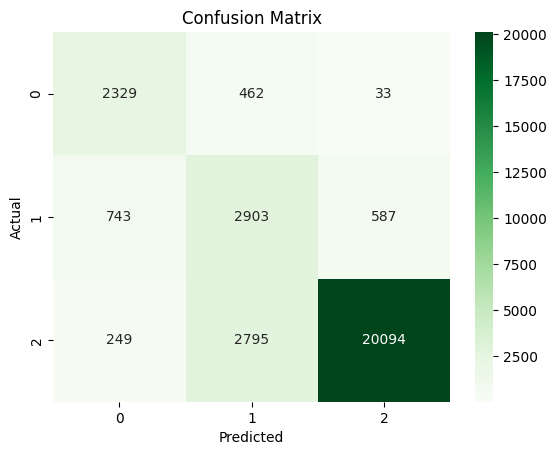

In [ ]:
#Get the predictions using the test data
Y_pred = logistic_regression_model.predict(X_final_test_TFIDF)

#Print accuracy
accuracy = accuracy_score(final_test_labels, Y_pred)
print("Accuracy: ", accuracy)

#Get confusion matrix
confusion = confusion_matrix(final_test_labels,Y_pred)
print("Confusion matrix")
print(confusion)

sns.heatmap(confusion, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

#Get classification report
report = classification_report(final_test_labels,Y_pred)
print("Classification: ")
print(report)